In [484]:
import pycaret
import pandas as pd

In [485]:
# อ่านไฟล์ CSV
data = pd.read_csv('export_data/filtered_data_3_best.csv')

In [486]:
# ตั้ง 'timestamp' เป็น index หากยังไม่ได้ทำ
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# ตั้งค่า freq ให้กับ index
data = data.asfreq('D')  # 'D' สำหรับรายวัน

In [487]:
# แสดงแถวที่มีค่าหายไปก่อนเติม
print("แถวที่มีค่าหายไปก่อนเติม:")
print(data[data.isnull().any(axis=1)])

# เติมค่าที่หายไปด้วยการ interpolate แบบเส้นตรง
data.interpolate(method='linear', inplace=True)

# แสดงแถวที่ยังมีค่า NaN หลังจากเติม (ถ้ามี)
missing_rows_after = data[data.isnull().any(axis=1)]
if not missing_rows_after.empty:
    print("แถวที่ยังมีค่าหายไปหลังเติม:")
    print(missing_rows_after)
else:
    print("ไม่มีค่าหายไปแล้ว")


row = data.loc["2023-09-30 07:00:00"]
row

แถวที่มีค่าหายไปก่อนเติม:
                     humidity  pm_10  pm_2_5  pm_2_5_sp  temperature
timestamp                                                           
2023-09-30 07:00:00       NaN    NaN     NaN        NaN          NaN
ไม่มีค่าหายไปแล้ว


humidity       82.889367
pm_10          60.525519
pm_2_5         53.415241
pm_2_5_sp      69.527667
temperature    29.219760
Name: 2023-09-30 07:00:00, dtype: float64

In [488]:
data = data[['pm_2_5', 'humidity', 'temperature']]

In [489]:
data["year"] = data.index.year
data["month"] = data.index.month
data["day"] = data.index.day
data["day_of_week"] = data.index.dayofweek  # 0 = Monday, 6 = Sunday
data["week_of_year"] = data.index.isocalendar().week  # ค่าจะเป็น int64

In [490]:
# สมมติว่า data มี index เป็น datetime อยู่แล้ว
def assign_season(month):
    if month in [2, 3, 4]:  # ก.พ. - เม.ย.
        return "summer"        # ฤดูร้อน
    elif month in [5, 6, 7]:  # พ.ค. - ก.ค.
        return "early_rainy"   # ต้นฤดูฝน
    else:  # ส.ค. - ม.ค.
        return "late_rainy"    # ปลายฤดูฝน

season_mapping = {'summer': 0, 'early_rainy': 1, 'late_rainy': 2}
data["season"] = data.index.month.map(assign_season)
data['season'] = data['season'].map(season_mapping)

In [491]:
data['dew_point'] = data['temperature'] - ((100 - data['humidity']) / 5)

In [492]:
data["is_weekend"] = data.index.dayofweek.isin([5, 6]).astype(int)

In [493]:
# อัตราส่วนของอุณหภูมิต่อความชื้น
data["temp_humidity_ratio"] = data["temperature"] / (data["humidity"] + 1)

In [494]:
# ดัชนีความร้อน (Heat Index) หรืออุณหภูมิที่รับรู้
T = data["temperature"]
RH = data["humidity"]

data["heat_index"] = -42.379 + (2.04901523 * T) + (10.14333127 * RH) - (0.22475541 * T * RH) - \
                   (0.00683783 * T**2) - (0.05481717 * RH**2) + (0.00122874 * T**2 * RH) + \
                   (0.00085282 * T * RH**2) - (0.00000199 * T**2 * RH**2)

In [495]:
# ความชื้นสัมพัทธ์เชิงดัชนี
data["rh_index"] = data["humidity"] ** 2 / (data["temperature"] + 1)

In [496]:
import pandas as pd
import numpy as np

# สมมุติว่ามี DataFrame data ที่มีข้อมูลอยู่แล้ว

# เพิ่มฟีเจอร์ day_of_year
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data['day_of_year'] = data['date'].dt.dayofyear

# เพิ่มฟีเจอร์ month_sin และ month_cos
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# เพิ่มฟีเจอร์ day_of_week_sin และ day_of_week_cos
data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

data['pm_2_5_lag_1'] = data['pm_2_5'].shift(1)
data['pm_2_5_lag_2'] = data['pm_2_5'].shift(2)
data['pm_2_5_lag_3'] = data['pm_2_5'].shift(3)
data['pm_2_5_lag_4'] = data['pm_2_5'].shift(4)
data['pm_2_5_lag_5'] = data['pm_2_5'].shift(5)
data['pm_2_5_lag_6'] = data['pm_2_5'].shift(6)
data['pm_2_5_lag_7'] = data['pm_2_5'].shift(7)

data['humidity_rolling_2'] = data['humidity'].rolling(window=2).mean().shift(1)  # ค่าเฉลี่ย 2 วันของ PM 10
data['humidity_rolling_3'] = data['humidity'].rolling(window=3).mean().shift(1)  # ค่าเฉลี่ย 3 วันของ PM 10
data['humidity_rolling_5'] = data['humidity'].rolling(window=5).mean().shift(1)  # ค่าเฉลี่ย 5 วันของ PM 10
data['humidity_rolling_7'] = data['humidity'].rolling(window=7).mean().shift(1)  # ค่าเฉลี่ย 7 วันของ PM 10

data['humidity_lag_1'] = data['humidity'].shift(1)
data['humidity_lag_2'] = data['humidity'].shift(2)
data['humidity_lag_3'] = data['humidity'].shift(3)
data['humidity_lag_5'] = data['humidity'].shift(5)
data['humidity_lag_7'] = data['humidity'].shift(7)

data['temperature_rolling_2'] = data['temperature'].rolling(window=2).mean().shift(1)  # ค่าเฉลี่ย 2 วันของ PM 10
data['temperature_rolling_3'] = data['temperature'].rolling(window=3).mean().shift(1)  # ค่าเฉลี่ย 3 วันของ PM 10
data['temperature_rolling_5'] = data['temperature'].rolling(window=5).mean().shift(1)  # ค่าเฉลี่ย 5 วันของ PM 10
data['temperature_rolling_7'] = data['temperature'].rolling(window=7).mean().shift(1)  # ค่าเฉลี่ย 7 วันของ PM 10

data['temperature_lag_1'] = data['temperature'].shift(1)
data['temperature_lag_2'] = data['temperature'].shift(2)
data['temperature_lag_3'] = data['temperature'].shift(3)
data['temperature_lag_5'] = data['temperature'].shift(5)
data['temperature_lag_7'] = data['temperature'].shift(7)


In [497]:
data["temp_diff"] = data["temperature"].diff()
data["humidity_diff"] = data["humidity"].diff()

In [498]:
data.columns

Index(['pm_2_5', 'humidity', 'temperature', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'season', 'dew_point', 'is_weekend',
       'temp_humidity_ratio', 'heat_index', 'rh_index', 'date', 'day_of_year',
       'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
       'pm_2_5_lag_1', 'pm_2_5_lag_2', 'pm_2_5_lag_3', 'pm_2_5_lag_4',
       'pm_2_5_lag_5', 'pm_2_5_lag_6', 'pm_2_5_lag_7', 'humidity_rolling_2',
       'humidity_rolling_3', 'humidity_rolling_5', 'humidity_rolling_7',
       'humidity_lag_1', 'humidity_lag_2', 'humidity_lag_3', 'humidity_lag_5',
       'humidity_lag_7', 'temperature_rolling_2', 'temperature_rolling_3',
       'temperature_rolling_5', 'temperature_rolling_7', 'temperature_lag_1',
       'temperature_lag_2', 'temperature_lag_3', 'temperature_lag_5',
       'temperature_lag_7', 'temp_diff', 'humidity_diff'],
      dtype='object')

In [499]:
data_filtered = data.loc['2023-09':]  # ดึงข้อมูลตั้งแต่กันยายน 2023 เป็นต้นไป

<Axes: xlabel='timestamp'>

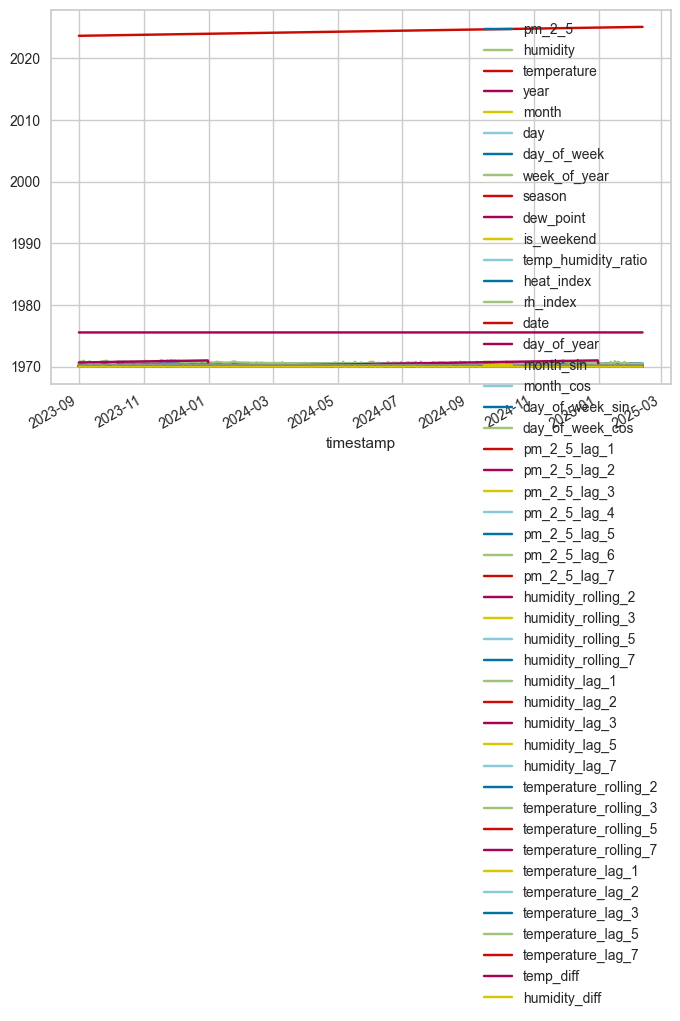

In [500]:
data_filtered.plot()

In [643]:
# สมมติว่า data มีจำนวนวันทั้งหมด
total_data = len(data_filtered)

# จำนวนวันที่ต้องการเป็น test data
test_days = 30

# คำนวณสัดส่วนของ 30 วันในข้อมูลทั้งหมด
test_size = test_days / total_data
test_size

0.05660377358490566

In [644]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_filtered, test_size=test_size, shuffle=False)

In [645]:
train_data.shape

(500, 47)

In [646]:
test_data.shape

(30, 47)

In [647]:
test_data.head(1)

,pm_2_5,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,...,temperature_rolling_3,temperature_rolling_5,temperature_rolling_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_5,temperature_lag_7,temp_diff,humidity_diff
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-13 07:00:00,42.594631,78.292202,25.997341,2025,1,13,0,3,2,21.655782,...,27.579379,28.008569,28.287636,25.434972,28.357459,28.945704,28.921543,28.825509,0.562369,-7.087604


In [621]:
test_data.tail(1)

,pm_2_5,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,...,temperature_rolling_3,temperature_rolling_5,temperature_rolling_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_5,temperature_lag_7,temp_diff,humidity_diff
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-11 07:00:00,27.522727,68.159624,28.693799,2025,2,11,1,7,0,22.325724,...,28.336846,28.372328,28.280646,28.251201,28.373742,28.385596,28.579177,27.775432,0.442598,-3.066711


In [622]:
test_data.tail()

,pm_2_5,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,...,temperature_rolling_3,temperature_rolling_5,temperature_rolling_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_5,temperature_lag_7,temp_diff,humidity_diff
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-07 07:00:00,29.321219,70.933952,28.271927,2025,2,7,4,6,0,22.458717,...,28.227353,28.202099,27.951803,28.579177,28.327450,27.775432,27.683890,27.336718,-0.307250,1.422170
2025-02-08 07:00:00,26.000000,69.348548,28.385596,2025,2,8,5,6,0,22.255305,...,28.392851,28.319706,28.085404,28.271927,28.579177,28.327450,28.644544,27.315410,0.113669,-1.585405
2025-02-09 07:00:00,24.616898,69.916384,28.373742,2025,2,9,6,6,0,22.357019,...,28.412233,28.267916,28.238288,28.385596,28.271927,28.579177,27.775432,27.683890,-0.011853,0.567837
2025-02-10 07:00:00,25.856981,71.226336,28.251201,2025,2,10,0,7,0,22.496468,...,28.343755,28.387578,28.336838,28.373742,28.385596,28.271927,28.327450,28.644544,-0.122542,1.309951
2025-02-11 07:00:00,27.522727,68.159624,28.693799,2025,2,11,1,7,0,22.325724,...,28.336846,28.372328,28.280646,28.251201,28.373742,28.385596,28.579177,27.775432,0.442598,-3.066711


In [508]:
test_data.columns

Index(['pm_2_5', 'humidity', 'temperature', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'season', 'dew_point', 'is_weekend',
       'temp_humidity_ratio', 'heat_index', 'rh_index', 'date', 'day_of_year',
       'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
       'pm_2_5_lag_1', 'pm_2_5_lag_2', 'pm_2_5_lag_3', 'pm_2_5_lag_4',
       'pm_2_5_lag_5', 'pm_2_5_lag_6', 'pm_2_5_lag_7', 'humidity_rolling_2',
       'humidity_rolling_3', 'humidity_rolling_5', 'humidity_rolling_7',
       'humidity_lag_1', 'humidity_lag_2', 'humidity_lag_3', 'humidity_lag_5',
       'humidity_lag_7', 'temperature_rolling_2', 'temperature_rolling_3',
       'temperature_rolling_5', 'temperature_rolling_7', 'temperature_lag_1',
       'temperature_lag_2', 'temperature_lag_3', 'temperature_lag_5',
       'temperature_lag_7', 'temp_diff', 'humidity_diff'],
      dtype='object')

In [509]:
# train_data.dropna()

In [648]:
# from pycaret.time_series import *
from pycaret.regression import RegressionExperiment
exp1 = RegressionExperiment()
exp1.setup(data=train_data, target='pm_2_5', session_id=123, fold=12, iterative_imputation_iters=100, remove_outliers = True)

,Description,Value
0,Session id,123
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(500, 47)"
4,Transformed data shape,"(482, 49)"
5,Transformed train set shape,"(332, 49)"
6,Transformed test set shape,"(150, 49)"
7,Numeric features,45
8,Date features,1
9,Preprocess,True


In [649]:
# compare baseline models
best = exp1.compare_models(n_select=17)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,5.1414,44.4269,6.5135,0.5240,0.3441,0.3260,0.0233
llar,Lasso Least Angle Regression,5.1380,44.4227,6.5133,0.5240,0.3440,0.3258,0.0250
omp,Orthogonal Matching Pursuit,5.1260,44.7433,6.5322,0.5204,0.3456,0.3276,0.0217
br,Bayesian Ridge,5.1871,44.9427,6.5568,0.5200,0.3467,0.3292,0.0208
en,Elastic Net,5.1661,44.8561,6.5455,0.5188,0.3461,0.3267,0.0242
huber,Huber Regressor,5.1051,45.8626,6.5876,0.5123,0.3446,0.3045,0.0225
ada,AdaBoost Regressor,5.4948,46.8333,6.7167,0.4986,0.3713,0.3821,0.0442
rf,Random Forest Regressor,5.3409,47.7500,6.7613,0.4920,0.3595,0.3502,0.1167
et,Extra Trees Regressor,5.3957,48.4793,6.7961,0.4891,0.3587,0.3521,0.0683
ridge,Ridge Regression,5.3869,48.0454,6.7964,0.4879,0.3825,0.3371,0.0233


In [677]:
model_1 = exp1.create_model('rf')
# model_1 = exp1.create_model('en')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.3579,29.0277,5.3877,0.6807,0.3253,0.3081
1,7.6513,111.1472,10.5426,0.3877,0.4394,0.3722
2,4.4803,27.1528,5.2108,0.6290,0.3914,0.4381
3,6.2824,60.4222,7.7732,0.4621,0.4221,0.4468
4,4.6795,50.8274,7.1293,0.5111,0.3036,0.2362
5,5.3698,43.9525,6.6297,0.2674,0.3954,0.4184
6,5.8911,51.2277,7.1574,0.1631,0.4115,0.4430
7,6.2668,56.0499,7.4866,0.5589,0.4038,0.4241
8,4.4609,27.9546,5.2872,0.6395,0.2934,0.2829


In [448]:
exp1.evaluate_model(model_1)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [449]:
tune_1 = exp1.tune_model(model_1)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.5911,28.3530,5.3248,0.6882,0.3247,0.3256
1,7.4143,105.0946,10.2516,0.4210,0.4112,0.3569
2,4.1192,23.6329,4.8614,0.6771,0.3666,0.4043
3,5.5077,41.3586,6.4311,0.6318,0.3683,0.3885
4,5.2511,63.9913,7.9995,0.3845,0.3179,0.2526
5,4.9630,36.4571,6.0380,0.3923,0.3725,0.3899
6,5.2752,43.5767,6.6013,0.2881,0.3738,0.3864
7,5.7255,49.5564,7.0396,0.6100,0.3786,0.3806
8,4.6523,29.5183,5.4331,0.6194,0.2745,0.2759


Fitting 12 folds for each of 10 candidates, totalling 120 fits


In [450]:
model_2 = exp1.create_model('huber')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.7459,31.3605,5.6000,0.6551,0.3052,0.2911
1,7.2796,109.8395,10.4804,0.3949,0.4221,0.3175
2,3.4646,18.3207,4.2803,0.7497,0.2812,0.2763
3,5.6367,46.0775,6.7880,0.5898,0.3792,0.3657
4,5.1851,62.0910,7.8798,0.4028,0.3152,0.2490
5,5.0321,42.6243,6.5287,0.2895,0.3984,0.3626
6,5.6793,50.8782,7.1329,0.1688,0.3703,0.3788
7,5.8734,50.2522,7.0889,0.6045,0.3898,0.3751
8,4.1032,24.1994,4.9193,0.6879,0.2575,0.2354


In [451]:
blend = exp1.blend_models([model_1, model_2])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.7625,31.1633,5.5824,0.6572,0.3128,0.3061
1,7.3101,105.4297,10.2679,0.4192,0.4123,0.3299
2,3.6610,19.8817,4.4589,0.7283,0.3062,0.3146
3,5.4462,42.8282,6.5443,0.6188,0.3601,0.3607
4,5.0910,60.7928,7.7970,0.4153,0.3112,0.2425
5,5.1026,41.5308,6.4444,0.3077,0.3832,0.3684
6,5.5742,49.7425,7.0528,0.1873,0.3824,0.3931
7,5.9070,48.9180,6.9941,0.6150,0.3790,0.3833
8,4.4181,26.4883,5.1467,0.6584,0.2707,0.2608


In [514]:
tune = exp1.tune_model(blend)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.7955,31.3805,5.6018,0.6549,0.3171,0.3131
1,7.3241,104.2588,10.2107,0.4256,0.4101,0.3342
2,3.7457,20.6241,4.5414,0.7182,0.3162,0.3285
3,5.3849,41.9686,6.4783,0.6264,0.3555,0.3591
4,5.0780,60.4972,7.7780,0.4181,0.3109,0.2411
5,5.1576,41.4909,6.4413,0.3084,0.3815,0.3743
6,5.5627,49.5671,7.0404,0.1902,0.3866,0.3991
7,5.9179,48.7264,6.9804,0.6165,0.3778,0.3859
8,4.5200,27.4615,5.2404,0.6459,0.2759,0.2691


Fitting 12 folds for each of 10 candidates, totalling 120 fits


In [679]:
new_data = test_data.copy().drop(['pm_2_5'], axis=1)
predictions = exp1.predict_model(model_1, data=new_data)
predictions

,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,is_weekend,...,temperature_rolling_5,temperature_rolling_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_5,temperature_lag_7,temp_diff,humidity_diff,prediction_label
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-13 07:00:00,78.292206,25.997341,2025,1,13,0,3,2,21.655781,0,...,28.008570,28.287636,25.434973,28.357460,28.945705,28.921543,28.825508,0.562369,-7.087604,29.024274
2025-01-14 07:00:00,74.887207,26.780884,2025,1,14,1,3,2,21.758324,0,...,27.423729,27.883612,25.997341,25.434973,28.357460,28.383165,29.145098,0.783542,-3.404998,35.406685
2025-01-15 07:00:00,74.201401,27.146723,2025,1,15,2,3,2,21.987003,0,...,27.103271,27.545866,26.780884,25.997341,25.434973,28.945705,28.921543,0.365839,-0.685802,36.554936
2025-01-16 07:00:00,89.873428,24.990604,2025,1,16,3,3,2,22.965288,0,...,26.743475,27.292320,27.146723,26.780884,25.997341,28.357460,28.383165,-2.156118,15.672023,34.052223
2025-01-17 07:00:00,80.848938,27.221664,2025,1,17,4,3,2,23.391453,0,...,26.070105,26.807669,24.990604,27.146723,26.780884,25.434973,28.945705,2.231061,-9.024486,35.557312
2025-01-18 07:00:00,83.512680,26.832436,2025,1,18,5,3,2,23.534971,1,...,26.427443,26.561378,27.221664,24.990604,27.146723,25.997341,28.357460,-0.389229,2.663738,20.644980
2025-01-19 07:00:00,85.338097,25.598782,2025,1,19,6,3,2,22.666401,1,...,26.594461,26.343517,26.832436,27.221664,24.990604,26.780884,25.434973,-1.233655,1.825418,20.730565
2025-01-20 07:00:00,84.719635,26.357235,2025,1,20,0,4,2,23.301161,0,...,26.358042,26.366919,25.598782,26.832436,27.221664,27.146723,25.997341,0.758453,-0.618461,25.202458
2025-01-21 07:00:00,72.150978,28.367937,2025,1,21,1,4,2,22.798134,0,...,26.200144,26.418333,26.357235,25.598782,26.832436,24.990604,26.780884,2.010702,-12.568653,37.999861


In [680]:
predict_v = predictions['prediction_label']
predict_v.head(7)

timestamp
2025-01-13 07:00:00    29.024274
2025-01-14 07:00:00    35.406685
2025-01-15 07:00:00    36.554936
2025-01-16 07:00:00    34.052223
2025-01-17 07:00:00    35.557312
2025-01-18 07:00:00    20.644980
2025-01-19 07:00:00    20.730565
Freq: D, Name: prediction_label, dtype: float64

In [681]:
real = test_data['pm_2_5']
real.head(7)

timestamp
2025-01-13 07:00:00    42.594631
2025-01-14 07:00:00    51.460606
2025-01-15 07:00:00    42.430233
2025-01-16 07:00:00    45.747352
2025-01-17 07:00:00    14.060993
2025-01-18 07:00:00    16.223140
2025-01-19 07:00:00    31.798226
Freq: D, Name: pm_2_5, dtype: float64

In [682]:
# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result = pd.concat([predict_v, test_data['pm_2_5']], axis=1)
result.columns = ['Predictions', 'Actual PM2_5']  # ตั้งชื่อคอลัมน์

# ทำนาย 1 วันข้างหน้า ต้องทำนายเผื่อ 2 วัน

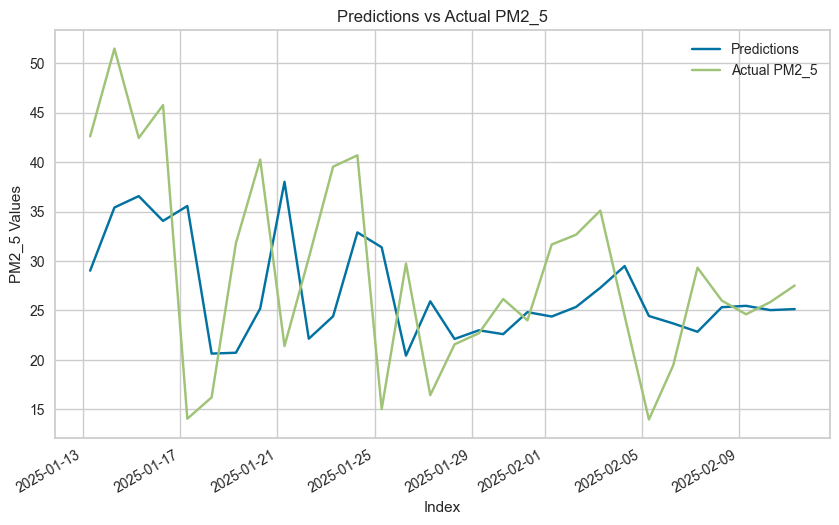

In [683]:
import pandas as pd
import matplotlib.pyplot as plt

# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result = pd.concat([predict_v, test_data['pm_2_5']], axis=1)
result.columns = ['Predictions', 'Actual PM2_5']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual PM2_5')
plt.xlabel('Index')
plt.ylabel('PM2_5 Values')

# แสดงกราฟ
plt.show()

In [458]:
# import pandas as pd
# from sklearn.metrics import mean_absolute_percentage_error, r2_score

# # สร้าง result จากการ shift ค่าทำนาย
# result = pd.concat([predict_v.shift(-1), test_data['pm_10']], axis=1)
# result.columns = ['predicted', 'actual']

# # ลบแถวที่มีค่า NaN
# result = result.dropna()

# # คำนวณ MAPE
# mape = mean_absolute_percentage_error(result['actual'], result['predicted']) * 100

# # คำนวณ R2
# r2 = r2_score(result['actual'], result['predicted'])

# print(f'MAPE: {mape}%')
# print(f'R²: {r2}')


In [459]:
# MAPE
# from itertools import combinations

# best_list = list(best)
# # เก็บชื่อโมเดลและอ็อบเจกต์ไว้ใน dict
# model_names = {model.__class__.__name__: model for model in best_list}

# # Dictionary เก็บค่า MAPE
# mape_results = {}

# loop = 1
# # วนลูปเลือกโมเดลทีละคู่
# for model1_name, model2_name in combinations(model_names.keys(), 2):
#     print(f"{loop} --> Blending: {model1_name} + {model2_name}")  # แสดงว่ากำลังประมวลผลคู่ไหน

#     # นำโมเดลทั้งสองมาผสมกัน
#     blended_model = exp1.blend_models([model_names[model1_name], model_names[model2_name]], verbose=False)
    
#     # ดึงค่าประเมินผลล่าสุด
#     result = exp1.pull()
#     # ตรวจสอบว่ามีคอลัมน์ 'MAPE' หรือไม่
#     if 'MAPE' in result.columns and 'Mean' in result.index:
#         mape_value = result.loc['Mean', 'MAPE']
#     elif 'R2' in result.columns and 'Mean' in result.index:
#         mape_value = result.loc['Mean', 'R2']
#     else:
#         print(f"❌ ไม่มีค่าที่ต้องการสำหรับ {model1_name} + {model2_name}")
#         continue  # ข้ามรอบนี้ถ้าไม่มีค่า MAPE หรือ R2

#     # บันทึกค่าลง dictionary
#     mape_results[f"{model1_name}, {model2_name}"] = mape_value

#     print('-'* 60)
#     loop += 1

In [460]:
# R2
# from itertools import combinations

# best_list = list(best)
# # เก็บชื่อโมเดลและอ็อบเจกต์ไว้ใน dict
# model_names = {model.__class__.__name__: model for model in best_list}

# # Dictionary เก็บค่า R2
# r2_results = {}

# loop = 1
# # วนลูปเลือกโมเดลทีละคู่
# for model1_name, model2_name in combinations(model_names.keys(), 2):
#     print(f"{loop} --> Blending: {model1_name} + {model2_name}")  # แสดงว่ากำลังประมวลผลคู่ไหน

#     # นำโมเดลทั้งสองมาผสมกัน
#     blended_model = exp1.blend_models([model_names[model1_name], model_names[model2_name]], verbose=False)
    
#     # ดึงค่าประเมินผลล่าสุด
#     result = exp1.pull()
    
#     # ตรวจสอบว่ามีคอลัมน์ 'R2' หรือไม่
#     if 'R2' in result.columns and 'Mean' in result.index:
#         r2_value = result.loc['Mean', 'R2']
#     else:
#         print(f"❌ ไม่มีค่า R2 สำหรับ {model1_name} + {model2_name}")
#         continue  # ข้ามรอบนี้ถ้าไม่มีค่า R2

#     # บันทึกค่าลง dictionary
#     r2_results[f"{model1_name}, {model2_name}"] = r2_value

#     print('-'* 60)
#     loop += 1


In [461]:
# print("\nผลลัพธ์ของการ Blend Models:")
# for blend, score in sorted(mape_results.items(), key=lambda x: x[1]):  # เรียงจาก R² สูงสุด
#     print(f"{blend}: {score}")

# Predict 1 by 1

30 วัน  
2025-01-13 07:00:00  
2025-02-11 07:00:00  
7 วัน  
2025-02-05  
2025-02-11  
24 วัน  
2025-01-19 07:00:00  
31 วัน
2025-01-12 07:00:00

In [ ]:
# model_1 = exp1.create_model('rf')
# tune_1 = exp1.tune_model(model_1)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.3579,29.0277,5.3877,0.6807,0.3253,0.3081
1,7.6513,111.1472,10.5426,0.3877,0.4394,0.3722
2,4.4803,27.1528,5.2108,0.6290,0.3914,0.4381
3,6.2824,60.4222,7.7732,0.4621,0.4221,0.4468
4,4.6795,50.8274,7.1293,0.5111,0.3036,0.2362
5,5.3698,43.9525,6.6297,0.2674,0.3954,0.4184
6,5.8911,51.2277,7.1574,0.1631,0.4115,0.4430
7,6.2668,56.0499,7.4866,0.5589,0.4038,0.4241
8,4.4609,27.9546,5.2872,0.6395,0.2934,0.2829


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.4410,30.5220,5.5247,0.6643,0.3278,0.3106
1,7.8606,111.3691,10.5532,0.3865,0.4452,0.3898
2,4.3757,25.0782,5.0078,0.6573,0.3785,0.4226
3,6.2848,59.5672,7.7180,0.4698,0.4195,0.4457
4,4.7080,54.9055,7.4098,0.4719,0.3105,0.2312
5,5.3670,44.2713,6.6537,0.2621,0.3932,0.4187
6,6.0097,53.2244,7.2955,0.1305,0.4155,0.4479
7,5.8103,49.2898,7.0207,0.6121,0.3839,0.3944
8,4.4802,28.8140,5.3679,0.6284,0.2928,0.2827


Fitting 12 folds for each of 10 candidates, totalling 120 fits


In [662]:
data_compare = data_filtered.loc[:'2025-01-12']
result = pd.DataFrame()

start_date = "2025-01-13"
end_date = "2025-02-11"

model = model_1

for date in pd.date_range(start=start_date, end=end_date, freq="D"):
    # Drop columns
    test_1 = data_filtered.drop(columns=['pm_2_5', 'pm_2_5_lag_1', 'pm_2_5_lag_2', 'pm_2_5_lag_3', 'pm_2_5_lag_4','pm_2_5_lag_5', 'pm_2_5_lag_6','pm_2_5_lag_7'])

    # ดึงวันนี้มา
    test_1 = test_1.loc[str(date.date())]

    # ใส่เข้าไป
    data_compare = pd.concat([data_compare, test_1], axis=0)

    # เพิ่มฟีเจอร์ rolling average (ค่าเฉลี่ยเคลื่อนที่)

    # data_compare['pm_2_5_rolling_7'] = data_compare['pm_2_5'].rolling(window=7).mean().shift(1)  # ค่าเฉลี่ย 5 วันของ PM 10

    data_compare['pm_2_5_lag_1'] = data_compare['pm_2_5'].shift(1)
    data_compare['pm_2_5_lag_2'] = data_compare['pm_2_5'].shift(2)
    data_compare['pm_2_5_lag_3'] = data_compare['pm_2_5'].shift(3)
    data_compare['pm_2_5_lag_4'] = data_compare['pm_2_5'].shift(4)
    data_compare['pm_2_5_lag_5'] = data_compare['pm_2_5'].shift(5)
    data_compare['pm_2_5_lag_6'] = data_compare['pm_2_5'].shift(6)
    data_compare['pm_2_5_lag_7'] = data_compare['pm_2_5'].shift(7)

    # ดึง
    test_1 = (data_compare.loc[str(date.date())]).drop(columns=['pm_2_5'])
    
    # Drop ทิ้งล่าสุดใน data_compare
    data_compare = data_compare.drop(data_compare.last_valid_index())
    test_1 = test_1[~test_1.index.duplicated(keep='last')]

    # Predict
    predict_test_1 = exp1.predict_model(model, data=test_1)

        # เพิ่มผลทำนายเข้าไปใน data_compare
    data_compare = pd.concat([data_compare, predict_test_1], axis=0)

    # แทนที่ค่าในคอลัมน์ 'pm_2_5' ในวันที่ '2025-01-13' ด้วยค่าในคอลัมน์ 'prediction_label'
    data_compare.loc[str(date.date()), 'pm_2_5'] = data_compare.loc[str(date.date()), 'prediction_label']

    # ลบคอลัมน์ 'prediction_label' (หากต้องการแค่ผลทำนาย)
    data_compare = data_compare.drop(columns=['prediction_label'])

    # กรองเอาวันที่ซ้ำกัน (index ซ้ำ) ออกให้เหลือแค่ตัวเดียว
    data_compare = data_compare[~data_compare.index.duplicated(keep='last')]

    # บันทึกลง result
    result = pd.concat([result, predict_test_1], axis=0)

In [579]:
data_compare[['pm_2_5', 'pm_2_5_lag_1', 'pm_2_5_lag_2', 'pm_2_5_lag_3', 'pm_2_5_lag_4','pm_2_5_lag_5', 'pm_2_5_lag_6','pm_2_5_lag_7']].tail(7)

,pm_2_5,pm_2_5_lag_1,pm_2_5_lag_2,pm_2_5_lag_3,pm_2_5_lag_4,pm_2_5_lag_5,pm_2_5_lag_6,pm_2_5_lag_7
timestamp,,,,,,,,
2025-02-05 07:00:00,25.181051,25.290904,25.859762,25.558865,25.166550,25.086018,25.043984,25.723475
2025-02-06 07:00:00,24.848436,25.181051,25.290904,25.859762,25.558865,25.166550,25.086018,25.043984
2025-02-07 07:00:00,25.138046,24.848436,25.181051,25.290904,25.859762,25.558865,25.166550,25.086018
2025-02-08 07:00:00,24.764700,25.138046,24.848436,25.181051,25.290904,25.859762,25.558865,25.166550
2025-02-09 07:00:00,24.636321,24.764700,25.138046,24.848436,25.181051,25.290904,25.859762,25.558865
2025-02-10 07:00:00,24.498710,24.636321,24.764700,25.138046,24.848436,25.181051,25.290904,25.859762
2025-02-11 07:00:00,24.311434,24.498711,24.636320,24.764700,25.138046,24.848436,25.181051,25.290905


In [580]:
test_data[['pm_2_5', 'pm_2_5_lag_1', 'pm_2_5_lag_2', 'pm_2_5_lag_3', 'pm_2_5_lag_4','pm_2_5_lag_5', 'pm_2_5_lag_6','pm_2_5_lag_7']].tail(7)

,pm_2_5,pm_2_5_lag_1,pm_2_5_lag_2,pm_2_5_lag_3,pm_2_5_lag_4,pm_2_5_lag_5,pm_2_5_lag_6,pm_2_5_lag_7
timestamp,,,,,,,,
2025-02-05 07:00:00,13.987089,24.459172,35.094660,32.655212,31.669725,24.003417,26.160959,22.697727
2025-02-06 07:00:00,19.454865,13.987089,24.459172,35.094660,32.655212,31.669725,24.003417,26.160959
2025-02-07 07:00:00,29.321219,19.454865,13.987089,24.459172,35.094660,32.655212,31.669725,24.003417
2025-02-08 07:00:00,26.000000,29.321219,19.454865,13.987089,24.459172,35.094660,32.655212,31.669725
2025-02-09 07:00:00,24.616898,26.000000,29.321219,19.454865,13.987089,24.459172,35.094660,32.655212
2025-02-10 07:00:00,25.856981,24.616898,26.000000,29.321219,19.454865,13.987089,24.459172,35.094660
2025-02-11 07:00:00,27.522727,25.856981,24.616898,26.000000,29.321219,19.454865,13.987089,24.459172


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

real_data = data_filtered.loc[start_date:end_date]
# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result_plot = pd.concat([result['prediction_label'].shift(1), real_data['pm_2_5']], axis=1)
result_plot.columns = ['Predictions', 'Actual PM10']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result_plot.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual PM10')
plt.xlabel('Index')
plt.ylabel('PM10 Values')

# แสดงกราฟ
plt.show()

NameError: name 'data_filtered' is not defined

In [684]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

y_true = real_data["pm_2_5"]
y_pred = result['prediction_label']# "prediction_label" contains predictions

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate Accuracy as (1 - (MAE / mean_actual)) * 100
mean_actual = np.mean(y_true)  # Mean of actual values
accuracy = (1 - (mae / mean_actual)) * 100  # Accuracy in percentage

# Print Results
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Lower is better
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # Lower is better
print(f"Accuracy: {accuracy:.2f}%")  # Accuracy percentage

KeyError: 'prediction_label'

In [671]:
# ค่า R² และ MAPE
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE in percentage

# การปรับสเกลของ R² (สมมติให้อยู่ในช่วง 0-100 เพื่อให้อยู่ในช่วงเดียวกับ MAPE)
r2_scaled = r2 * 100  # เปลี่ยน R² ให้เป็นค่าร้อยละ

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")



R² Score: -0.0351
Mean Absolute Percentage Error (MAPE): 29.93%
